In [9]:
import numpy as np,os
import pandas as pd
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectFromModel
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier
from imblearn.pipeline import make_pipeline
import seaborn as sns,matplotlib.pyplot as plt
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import scikit_posthocs as sp
import matplotlib.pyplot as plt

from library.utils import evaluate, read_data

In [4]:
DATASETS = ['groovy-1_5_7.csv','jruby-1.4.0.csv','lucene-2.9.0.csv','jruby-1.7.0.preview1.csv','groovy-1_6_BETA_1.csv',
        'derby-10.2.1.6.csv','wicket-1.5.3.csv','camel-2.9.0.csv','camel-1.4.0.csv','activemq-5.8.0.csv']
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]
len(DATASETS)

32

In [5]:
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
def pr_rec_score(y,yp):
    prec, rec, _ = precision_recall_curve(y,yp)
    return auc(rec,prec)
scorers = [matthews_corrcoef,pr_rec_score]

# Feature Selection

## Notes
+ Smote,selectK(chi2): For PR-AUC, 65 ranked top, noticebaly better, sign. difference. No diff. for mathew, 65 2nd best. Colcusion: This feature selection method doesn't improve
+ Wilson,selectK(chi2): For PR-AUC, sig diff, 65 & 50 top 2. For Mathew, no sig. diff.
+ smote, Sel from Model (L SVC): For PR-AUC, sig diff, lower the features, lower performance. For Mathew, no diff, no pattern either
+ Feature corr. seems pretty high. 313 pairs (7%) have more than .8 corr for some dataset.

In [7]:
clf = make_pipeline(SMOTE(),GaussianNB())
# M = 20
# rfe = RFE(RandomForestClassifier(n_estimators=50),n_features_to_select=M,step=2)
# topK = SelectKBest(score_func=chi2,k=M)
# pipe = Pipeline([
#     ('feat',topK),
#     ('clf',clf)
# ])

In [12]:
Ms = [10,20,30,40,50,65]
cols = pd.MultiIndex.from_product([Ms,[f.__name__ for f in scorers]],names=['Feats','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)

for m in Ms:
    print(m)
    rfe = RFE(RandomForestClassifier(n_estimators=50),n_features_to_select=m,step=2)
    topK = SelectKBest(score_func=chi2,k=m)
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False,max_iter=2000)
    sel_mod = SelectFromModel(lsvc, prefit=False,threshold=-np.inf,max_features=m)
    
    pipe = Pipeline([
        ('feat',sel_mod),
        ('clf',clf)
    ])

    for d in DATASETS:
        X,y_noisy,y_real = read_data(d,stats=True)
        r = evaluate(pipe,X,y_noisy,y_real,cv,scorers)
        for f in r:
            df.loc[d,(m,f)] = r[f].mean()

10
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-incubating-beta-1.csv noise:0.164, imb:4.806,288,1384, Shape:(1672, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


jruby-1.1.csv noise:0.175, imb:3.540,161,570, Shape:(731, 65)
jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


lucene-2.3.0.csv noise:0.204, imb:4.031,160,645, Shape:(805, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


hbase-0.95.2.csv noise:0.260, imb:15.088,114,1720, Shape:(1834, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.0.0.csv noise:0.185, imb:6.037,190,1147, Shape:(1337, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.9.0.csv noise:0.044, imb:34.600,200,6920, Shape:(7120, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.5.3.csv noise:0.064, imb:26.720,93,2485, Shape:(2578, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.1.csv noise:0.120, imb:7.477,331,2475, Shape:(2806, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_2.csv noise:0.096, imb:7.583,103,781, Shape:(884, 65)
activemq-5.2.0.csv noise:0.113, imb:12.247,154,1886, Shape:(2040, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
hbase-0.95.0.csv noise:0.234, imb:17.341,91,1578, Shape:(1669, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.11.0.csv noise:0.024, imb:43.230,200,8646, Shape:(8846, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.10.0.csv noise:0.126, imb:29.000,52,1508, Shape:(1560, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.10.0.csv noise:0.053, imb:24.447,311,7603, Shape:(7914, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.2.1.6.csv noise:0.290, imb:9.906,180,1783, Shape:(1963, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.5.0.csv noise:0.218, imb:3.098,276,855, Shape:(1131, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.3.1.4.csv noise:0.267, imb:13.051,157,2049, Shape:(2206, 65)
lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hbase-0.94.0.csv noise:0.207, imb:14.348,69,990, Shape:(1059, 65)
camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.1.0.csv noise:0.083, imb:13.173,139,1831, Shape:(1970, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.0.0.csv noise:0.139, imb:21.976,82,1802, Shape:(1884, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.5.1.1.csv noise:0.126, imb:14.028,180,2525, Shape:(2705, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-beta2.csv noise:0.184, imb:4.780,305,1458, Shape:(1763, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.12.0.csv noise:0.087, imb:56.870,46,2616, Shape:(2662, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.9.0.csv noise:0.179, imb:25.717,53,1363, Shape:(1416, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

20
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-incubating-beta-1.csv noise:0.164, imb:4.806,288,1384, Shape:(1672, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


jruby-1.1.csv noise:0.175, imb:3.540,161,570, Shape:(731, 65)
jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)
lucene-2.3.0.csv noise:0.204, imb:4.031,160,645, Shape:(805, 65)
hbase-0.95.2.csv noise:0.260, imb:15.088,114,1720, Shape:(1834, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.0.0.csv noise:0.185, imb:6.037,190,1147, Shape:(1337, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.9.0.csv noise:0.044, imb:34.600,200,6920, Shape:(7120, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.5.3.csv noise:0.064, imb:26.720,93,2485, Shape:(2578, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.1.csv noise:0.120, imb:7.477,331,2475, Shape:(2806, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_2.csv noise:0.096, imb:7.583,103,781, Shape:(884, 65)
activemq-5.2.0.csv noise:0.113, imb:12.247,154,1886, Shape:(2040, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
hbase-0.95.0.csv noise:0.234, imb:17.341,91,1578, Shape:(1669, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.11.0.csv noise:0.024, imb:43.230,200,8646, Shape:(8846, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.10.0.csv noise:0.126, imb:29.000,52,1508, Shape:(1560, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.10.0.csv noise:0.053, imb:24.447,311,7603, Shape:(7914, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.2.1.6.csv noise:0.290, imb:9.906,180,1783, Shape:(1963, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.5.0.csv noise:0.218, imb:3.098,276,855, Shape:(1131, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.3.1.4.csv noise:0.267, imb:13.051,157,2049, Shape:(2206, 65)
lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hbase-0.94.0.csv noise:0.207, imb:14.348,69,990, Shape:(1059, 65)
camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.1.0.csv noise:0.083, imb:13.173,139,1831, Shape:(1970, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.0.0.csv noise:0.139, imb:21.976,82,1802, Shape:(1884, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.5.1.1.csv noise:0.126, imb:14.028,180,2525, Shape:(2705, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-beta2.csv noise:0.184, imb:4.780,305,1458, Shape:(1763, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.12.0.csv noise:0.087, imb:56.870,46,2616, Shape:(2662, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.9.0.csv noise:0.179, imb:25.717,53,1363, Shape:(1416, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

30
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-incubating-beta-1.csv noise:0.164, imb:4.806,288,1384, Shape:(1672, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


jruby-1.1.csv noise:0.175, imb:3.540,161,570, Shape:(731, 65)
jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


lucene-2.3.0.csv noise:0.204, imb:4.031,160,645, Shape:(805, 65)
hbase-0.95.2.csv noise:0.260, imb:15.088,114,1720, Shape:(1834, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.0.0.csv noise:0.185, imb:6.037,190,1147, Shape:(1337, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.9.0.csv noise:0.044, imb:34.600,200,6920, Shape:(7120, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.5.3.csv noise:0.064, imb:26.720,93,2485, Shape:(2578, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.1.csv noise:0.120, imb:7.477,331,2475, Shape:(2806, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_2.csv noise:0.096, imb:7.583,103,781, Shape:(884, 65)
activemq-5.2.0.csv noise:0.113, imb:12.247,154,1886, Shape:(2040, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
hbase-0.95.0.csv noise:0.234, imb:17.341,91,1578, Shape:(1669, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.11.0.csv noise:0.024, imb:43.230,200,8646, Shape:(8846, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.10.0.csv noise:0.126, imb:29.000,52,1508, Shape:(1560, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.10.0.csv noise:0.053, imb:24.447,311,7603, Shape:(7914, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.2.1.6.csv noise:0.290, imb:9.906,180,1783, Shape:(1963, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.5.0.csv noise:0.218, imb:3.098,276,855, Shape:(1131, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.3.1.4.csv noise:0.267, imb:13.051,157,2049, Shape:(2206, 65)
lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hbase-0.94.0.csv noise:0.207, imb:14.348,69,990, Shape:(1059, 65)
camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.1.0.csv noise:0.083, imb:13.173,139,1831, Shape:(1970, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.0.0.csv noise:0.139, imb:21.976,82,1802, Shape:(1884, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.5.1.1.csv noise:0.126, imb:14.028,180,2525, Shape:(2705, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-beta2.csv noise:0.184, imb:4.780,305,1458, Shape:(1763, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.12.0.csv noise:0.087, imb:56.870,46,2616, Shape:(2662, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.9.0.csv noise:0.179, imb:25.717,53,1363, Shape:(1416, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

40
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-incubating-beta-1.csv noise:0.164, imb:4.806,288,1384, Shape:(1672, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


jruby-1.1.csv noise:0.175, imb:3.540,161,570, Shape:(731, 65)
jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)
lucene-2.3.0.csv noise:0.204, imb:4.031,160,645, Shape:(805, 65)
hbase-0.95.2.csv noise:0.260, imb:15.088,114,1720, Shape:(1834, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.0.0.csv noise:0.185, imb:6.037,190,1147, Shape:(1337, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.9.0.csv noise:0.044, imb:34.600,200,6920, Shape:(7120, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.5.3.csv noise:0.064, imb:26.720,93,2485, Shape:(2578, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.1.csv noise:0.120, imb:7.477,331,2475, Shape:(2806, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_2.csv noise:0.096, imb:7.583,103,781, Shape:(884, 65)
activemq-5.2.0.csv noise:0.113, imb:12.247,154,1886, Shape:(2040, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
hbase-0.95.0.csv noise:0.234, imb:17.341,91,1578, Shape:(1669, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.11.0.csv noise:0.024, imb:43.230,200,8646, Shape:(8846, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.10.0.csv noise:0.126, imb:29.000,52,1508, Shape:(1560, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.10.0.csv noise:0.053, imb:24.447,311,7603, Shape:(7914, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.2.1.6.csv noise:0.290, imb:9.906,180,1783, Shape:(1963, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.5.0.csv noise:0.218, imb:3.098,276,855, Shape:(1131, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.3.1.4.csv noise:0.267, imb:13.051,157,2049, Shape:(2206, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hbase-0.94.0.csv noise:0.207, imb:14.348,69,990, Shape:(1059, 65)
camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.1.0.csv noise:0.083, imb:13.173,139,1831, Shape:(1970, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.0.0.csv noise:0.139, imb:21.976,82,1802, Shape:(1884, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.5.1.1.csv noise:0.126, imb:14.028,180,2525, Shape:(2705, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-beta2.csv noise:0.184, imb:4.780,305,1458, Shape:(1763, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.12.0.csv noise:0.087, imb:56.870,46,2616, Shape:(2662, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.9.0.csv noise:0.179, imb:25.717,53,1363, Shape:(1416, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

50
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-incubating-beta-1.csv noise:0.164, imb:4.806,288,1384, Shape:(1672, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.1.csv noise:0.175, imb:3.540,161,570, Shape:(731, 65)
jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


lucene-2.3.0.csv noise:0.204, imb:4.031,160,645, Shape:(805, 65)
hbase-0.95.2.csv noise:0.260, imb:15.088,114,1720, Shape:(1834, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.0.0.csv noise:0.185, imb:6.037,190,1147, Shape:(1337, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.9.0.csv noise:0.044, imb:34.600,200,6920, Shape:(7120, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.5.3.csv noise:0.064, imb:26.720,93,2485, Shape:(2578, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.1.csv noise:0.120, imb:7.477,331,2475, Shape:(2806, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_2.csv noise:0.096, imb:7.583,103,781, Shape:(884, 65)
activemq-5.2.0.csv noise:0.113, imb:12.247,154,1886, Shape:(2040, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
hbase-0.95.0.csv noise:0.234, imb:17.341,91,1578, Shape:(1669, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.11.0.csv noise:0.024, imb:43.230,200,8646, Shape:(8846, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.10.0.csv noise:0.126, imb:29.000,52,1508, Shape:(1560, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.10.0.csv noise:0.053, imb:24.447,311,7603, Shape:(7914, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.2.1.6.csv noise:0.290, imb:9.906,180,1783, Shape:(1963, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.5.0.csv noise:0.218, imb:3.098,276,855, Shape:(1131, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.3.1.4.csv noise:0.267, imb:13.051,157,2049, Shape:(2206, 65)
lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hbase-0.94.0.csv noise:0.207, imb:14.348,69,990, Shape:(1059, 65)
camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.1.0.csv noise:0.083, imb:13.173,139,1831, Shape:(1970, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.0.0.csv noise:0.139, imb:21.976,82,1802, Shape:(1884, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.5.1.1.csv noise:0.126, imb:14.028,180,2525, Shape:(2705, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-beta2.csv noise:0.184, imb:4.780,305,1458, Shape:(1763, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.12.0.csv noise:0.087, imb:56.870,46,2616, Shape:(2662, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.9.0.csv noise:0.179, imb:25.717,53,1363, Shape:(1416, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

65
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-incubating-beta-1.csv noise:0.164, imb:4.806,288,1384, Shape:(1672, 65)
jruby-1.1.csv noise:0.175, imb:3.540,161,570, Shape:(731, 65)
jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


lucene-2.3.0.csv noise:0.204, imb:4.031,160,645, Shape:(805, 65)
hbase-0.95.2.csv noise:0.260, imb:15.088,114,1720, Shape:(1834, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.0.0.csv noise:0.185, imb:6.037,190,1147, Shape:(1337, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.9.0.csv noise:0.044, imb:34.600,200,6920, Shape:(7120, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.5.3.csv noise:0.064, imb:26.720,93,2485, Shape:(2578, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

lucene-3.1.csv noise:0.120, imb:7.477,331,2475, Shape:(2806, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_6_BETA_2.csv noise:0.096, imb:7.583,103,781, Shape:(884, 65)
activemq-5.2.0.csv noise:0.113, imb:12.247,154,1886, Shape:(2040, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

groovy-1_5_7.csv noise:0.085, imb:8.463,80,677, Shape:(757, 65)
hbase-0.95.0.csv noise:0.234, imb:17.341,91,1578, Shape:(1669, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.11.0.csv noise:0.024, imb:43.230,200,8646, Shape:(8846, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.7.0.preview1.csv noise:0.099, imb:8.902,163,1451, Shape:(1614, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.10.0.csv noise:0.126, imb:29.000,52,1508, Shape:(1560, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

camel-2.10.0.csv noise:0.053, imb:24.447,311,7603, Shape:(7914, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.2.1.6.csv noise:0.290, imb:9.906,180,1783, Shape:(1963, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

jruby-1.5.0.csv noise:0.218, imb:3.098,276,855, Shape:(1131, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.3.1.4.csv noise:0.267, imb:13.051,157,2049, Shape:(2206, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


lucene-2.9.0.csv noise:0.226, imb:3.921,278,1090, Shape:(1368, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hbase-0.94.0.csv noise:0.207, imb:14.348,69,990, Shape:(1059, 65)
camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.1.0.csv noise:0.083, imb:13.173,139,1831, Shape:(1970, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

activemq-5.0.0.csv noise:0.139, imb:21.976,82,1802, Shape:(1884, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

derby-10.5.1.1.csv noise:0.126, imb:14.028,180,2525, Shape:(2705, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

wicket-1.3.0-beta2.csv noise:0.184, imb:4.780,305,1458, Shape:(1763, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.12.0.csv noise:0.087, imb:56.870,46,2616, Shape:(2662, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

hive-0.9.0.csv noise:0.179, imb:25.717,53,1363, Shape:(1416, 65)


/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblin

## Analysis

In [13]:
df

Feats                                             10               \
metric                             matthews_corrcoef pr_rec_score   
activemq-5.8.0.csv                          0.272885      0.28749   
groovy-1_6_BETA_1.csv                       0.311559     0.406775   
activemq-5.3.0.csv                          0.324318     0.425936   
wicket-1.3.0-incubating-beta-1.csv          0.305868      0.36079   
jruby-1.1.csv                               0.446238     0.697501   
jruby-1.4.0.csv                             0.421134      0.57661   
lucene-2.3.0.csv                            0.388786     0.546151   
hbase-0.95.2.csv                            0.301024     0.474956   
lucene-3.0.0.csv                            0.293257      0.29194   
camel-2.9.0.csv                             0.232597     0.240189   
wicket-1.5.3.csv                            0.236244     0.181685   
lucene-3.1.csv                              0.170854     0.227925   
groovy-1_6_BETA_2.csv                       0.306612     0.380863   
activemq-5.2.0.csv                          0.396374     0.454021   
groovy-1_5_7.csv                             0.27302     0.572959   
hbase-0.95.0.csv                            0.255653     0.423484   
camel-2.11.0.csv                            0.185438     0.165785   
jruby-1.7.0.preview1.csv                    0.299069     0.389577   
hive-0.10.0.csv                             0.381476     0.411488   
camel-2.10.0.csv                            0.253695     0.243689   
derby-10.2.1.6.csv                          0.416993     0.659348   
jruby-1.5.0.csv                             0.365148     0.507733   
derby-10.3.1.4.csv                          0.403883     0.618156   
lucene-2.9.0.csv                             0.33535     0.460402   
hbase-0.94.0.csv                            0.377605     0.507028   
camel-1.4.0.csv                             0.337194     0.478907   
activemq-5.1.0.csv                          0.315874     0.390924   
activemq-5.0.0.csv                          0.397422     0.506925   
derby-10.5.1.1.csv                          0.358227     0.447217   
wicket-1.3.0-beta2.csv                      0.314442      0.35523   
hive-0.12.0.csv                             0.151571     0.164426   
hive-0.9.0.csv                              0.476502     0.610916   

Feats                                             20               \
metric                             matthews_corrcoef pr_rec_score   
activemq-5.8.0.csv                          0.276309      0.33283   
groovy-1_6_BETA_1.csv                       0.295959     0.392781   
activemq-5.3.0.csv                          0.331761     0.436545   
wicket-1.3.0-incubating-beta-1.csv          0.295415     0.360314   
jruby-1.1.csv                               0.430749     0.689538   
jruby-1.4.0.csv                             0.454325     0.598851   
lucene-2.3.0.csv                            0.467089     0.634332   
hbase-0.95.2.csv                             0.29745     0.473955   
lucene-3.0.0.csv                            0.303814     0.299105   
camel-2.9.0.csv                             0.209301     0.263382   
wicket-1.5.3.csv                            0.232255     0.214383   
lucene-3.1.csv                              0.168288     0.217266   
groovy-1_6_BETA_2.csv                       0.294121     0.337921   
activemq-5.2.0.csv                          0.410754     0.482049   
groovy-1_5_7.csv                            0.247247     0.442301   
hbase-0.95.0.csv                            0.265449     0.442631   
camel-2.11.0.csv                            0.172379     0.187011   
jruby-1.7.0.preview1.csv                    0.312114     0.381292   
hive-0.10.0.csv                             0.398104     0.434751   
camel-2.10.0.csv                            0.243159     0.271278   
derby-10.2.1.6.csv                          0.439704     0.672159   
jruby-1.5.0.csv                             0.364752     0.545849 

In [18]:
mat = df.drop(columns=['pr_rec_score'],axis=1,level=1).droplevel(1,axis=1)
mat

Feats,10,20,30,40,50,65
activemq-5.8.0.csv,0.272885,0.276309,0.284844,0.285928,0.2856,0.288513
groovy-1_6_BETA_1.csv,0.311559,0.295959,0.27647,0.276079,0.281771,0.255255
activemq-5.3.0.csv,0.324318,0.331761,0.34018,0.348002,0.340331,0.338475
wicket-1.3.0-incubating-beta-1.csv,0.305868,0.295415,0.309159,0.315454,0.317417,0.31573
jruby-1.1.csv,0.446238,0.430749,0.41855,0.39811,0.384644,0.378226
jruby-1.4.0.csv,0.421134,0.454325,0.441541,0.44038,0.434679,0.462466
lucene-2.3.0.csv,0.388786,0.467089,0.467842,0.472793,0.408538,0.446427
hbase-0.95.2.csv,0.301024,0.29745,0.303098,0.297856,0.307383,0.307795
lucene-3.0.0.csv,0.293257,0.303814,0.297344,0.320601,0.308059,0.293893
camel-2.9.0.csv,0.232597,0.209301,0.222984,0.225148,0.193938,0.22688


In [19]:
res = mat.copy()
for d in mat.index:
    res.loc[d] = rankdata(1-mat.loc[d])
res

Feats,10,20,30,40,50,65
activemq-5.8.0.csv,6,5,4,2,3,1
groovy-1_6_BETA_1.csv,1,2,4,5,3,6
activemq-5.3.0.csv,6,5,3,1,2,4
wicket-1.3.0-incubating-beta-1.csv,5,6,4,3,1,2
jruby-1.1.csv,1,2,3,4,5,6
jruby-1.4.0.csv,6,2,3,4,5,1
lucene-2.3.0.csv,6,3,2,1,5,4
hbase-0.95.2.csv,4,6,3,5,2,1
lucene-3.0.0.csv,6,3,4,1,2,5
camel-2.9.0.csv,1,5,4,3,6,2


In [20]:
res.mean().sort_values()

Feats
40    2.78125
30    3.21875
65    3.56250
20    3.62500
10    3.78125
50    4.03125
dtype: float64

In [21]:
friedmanchisquare(*(mat[c] for c in mat.columns))

FriedmanchisquareResult(statistic=8.928571428571445, pvalue=0.11194734550428516)

## Feature Correlation

In [97]:
import seaborn as sns
X,y_noisy,y_real = read_data(DATASETS[0],stats=True)
d = pd.DataFrame(X)
corr = d.corr(method='pearson')
np.isnan(corr).sum().sum(),np.isnan(X).sum().sum()

activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)


(129, 0)

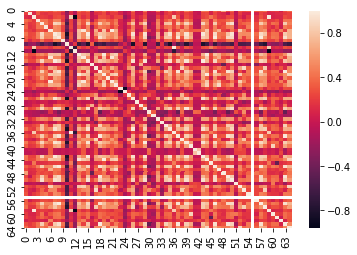

In [98]:
sns.heatmap(corr);

In [99]:
((corr>.80).sum().sum()-65)

303

In [100]:
X[55]

array([0.        , 0.        , 0.69314718, 0.69314718, 2.30258509,
       0.69314718, 0.69314718, 3.76120012, 1.09861229, 0.        ,
       0.40546511, 0.69314718, 0.69314718, 1.09861229, 1.09861229,
       3.63758616, 1.09861229, 2.77258872, 1.09861229, 0.69314718,
       0.        , 0.69314718, 0.69314718, 1.38629436, 0.39589566,
       0.69314718, 3.33220451, 0.        , 3.09104245, 2.99573227,
       0.69314718, 1.38629436, 0.69314718, 0.        , 0.69314718,
       2.99573227, 0.69314718, 1.09861229, 2.94443898, 2.94443898,
       1.09861229, 0.        , 0.69314718, 3.55534806, 0.69314718,
       4.26267988, 1.38629436, 0.69314718, 4.61512052, 1.09861229,
       4.26267988, 0.69314718, 0.        , 2.14006616, 0.69314718,
       0.        , 0.        , 1.09861229, 2.7080502 , 0.69314718,
       0.91629073, 0.        , 0.69314718, 1.09861229, 0.        ])

In [96]:
corr[55]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
60   NaN
61   NaN
62   NaN
63   NaN
64   NaN
Name: 55, Length: 65, dtype: float64

In [103]:
X[55].std()

1.238547470684771

# PCA

### Transformation, No Reduction
+ For PR-AUC, No PCA hell of lot better, beating PCA 100% cases 
+ Mathew: Still lot better in avg, beats 89% cases

### Components=30
+ Exactly same story as above

Same story after StandardScaling

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [57]:
imbs = {
    'smote': SMOTE(k_neighbors=5),
    'rus': RandomUnderSampler('not minority'),
    'wilson':EditedNearestNeighbours(n_neighbors=5),  #Default was 3
}
models = {}
for k,im in imbs.items():
    models[("No",k)] = make_pipeline(im,GaussianNB())
    models[("PCA",k)] = Pipeline([
        ('scale',StandardScaler()),
        ('pca',PCA(n_components=30)),
        ('clf',make_pipeline(im,GaussianNB()))
    ])
models.keys()

dict_keys([('No', 'smote'), ('PCA', 'smote'), ('No', 'rus'), ('PCA', 'rus'), ('No', 'wilson'), ('PCA', 'wilson')])

In [58]:
cols = pd.MultiIndex.from_product([['No','PCA'],imbs.keys(),[f.__name__ for f in scorers]],names=['pca','imb','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)

In [59]:
for k in models:
    print(k)
    for d in DATASETS:
        X,y_noisy,y_real = read_data(d,stats=False)
        r = evaluate(models[k],X,y_noisy,y_real,cv,scorers)
        for f in r:
            df.loc[d,(k[0],k[1],f)] = r[f].mean()

('No', 'smote')
('PCA', 'smote')
('No', 'rus')
('PCA', 'rus')
('No', 'wilson')
('PCA', 'wilson')


In [64]:
mat = df.drop(columns=['pr_rec_score'],axis=1,level=2).droplevel(2,axis=1) #pr_rec_score,matthews_corrcoef
mat

pca                                       No                            PCA  \
imb                                    smote       rus    wilson      smote   
activemq-5.8.0.csv                  0.289401  0.281098  0.287959   0.287689   
groovy-1_6_BETA_1.csv               0.262342  0.246201  0.262472   0.351514   
activemq-5.3.0.csv                  0.336011  0.331443  0.341537   0.358542   
wicket-1.3.0-incubating-beta-1.csv  0.314116  0.331716  0.311661   0.278011   
jruby-1.1.csv                       0.381643  0.393916  0.356364   0.430579   
jruby-1.4.0.csv                     0.451324  0.451153  0.412191    0.39517   
lucene-2.3.0.csv                    0.441953  0.390252  0.427834   0.452106   
hbase-0.95.2.csv                    0.308184  0.311659  0.319222   0.222984   
lucene-3.0.0.csv                    0.289508  0.291487  0.301087    0.20035   
camel-2.9.0.csv                     0.230774  0.235421  0.234136   0.201035   
wicket-1.5.3.csv                    0.205723  0.232335  0.225458   0.188337   
lucene-3.1.csv                       0.18683  0.181285  0.182073   0.150253   
groovy-1_6_BETA_2.csv               0.252291  0.235789  0.270493   0.291619   
activemq-5.2.0.csv                    0.3909   0.40132  0.404726   0.452112   
groovy-1_5_7.csv                    0.264248   0.25211  0.243429   0.273086   
hbase-0.95.0.csv                    0.263667   0.27131  0.263184   0.176625   
camel-2.11.0.csv                    0.181961  0.163009   0.17712   0.200343   
jruby-1.7.0.preview1.csv            0.288989  0.307277  0.302473   0.290009   
hive-0.10.0.csv                     0.410559  0.394347  0.411769   0.290995   
camel-2.10.0.csv                    0.243934  0.248122  0.241411   0.225998   
derby-10.2.1.6.csv                   0.43576  0.422739  0.440167   0.393448   
jruby-1.5.0.csv                     0.365348  0.365133  0.319211   0.276713   
derby-10.3.1.4.csv                  0.411547  0.391722  0.390938    0.31367   
lucene-2.9.0.csv                    0.326517   0.32452    0.3096   0.245725   
hbase-0.94.0.csv                    0.416946  0.374431  0.397964   0.311752   
camel-1.4.0.csv                     0.327265  0.313102  0.337749   0.269938   
activemq-5.1.0.csv                  0.315781  0.304208  0.308111    0.32615   
activemq-5.0.0.csv                  0.449498  0.432107  0.445431   0.434512   
derby-10.5.1.1.csv                  0.377496  0.385972  0.389488   0.346229   
wicket-1.3.0-beta2.csv              0.308762  0.307078  0.296803    0.23334   
hive-0.12.0.csv                     0.188874   0.16195  0.161285  0.0638728   
hive-0.9.0.csv                      0.471257  0.441592  0.480342   0.347906   

pca                                                      
imb                                      rus     wilson  
activemq-5.8.0.csv                  0.264336   0.275289  
groovy-1_6_BETA_1.csv               0.172615    0.19168  
activemq-5.3.0.csv                  0.310817   0.303244  
wicket-1.3.0-incubating-beta-1.csv  0.245531   0.256673  
jruby-1.1.csv                       0.360289   0.346547  
jruby-1.4.0.csv                     0.368105   0.372076  
lucene-2.3.0.csv                    0.401269   0.385702  
hbase-0.95.2.csv                    0.209653   0.188827  
lucene-3.0.0.csv                      0.2384   0.234992  
camel-2.9.0.csv                      0.18244   0.184035  
wicket-1.5.3.csv                    0.180722   0.180624  
lucene-3.1.csv                      0.134129   0.135177  
groovy-1_6_BETA_2.csv               0.151994   0.207697  
activemq-5.2.0.csv                  0.383781   0.435292  
groovy-1_5_7.csv                    0.220851   0.242104  
hbase-0.95.0.csv                    0.168351   0.136104  
camel-2.11.0.csv                    0.144115   0.125296  
jruby-1.7.0.preview1.csv            0.260002   0.262466  
hive-0.10.0.csv                     0.239685   0.252143  
camel-2.10.0.csv                    0.208867   0.201931  
derby-10.2.1.6.csv                  0

In [65]:
a = mat.loc[:,("No",slice(None))].values.reshape(-1)
b = mat.loc[:,("PCA",slice(None))].values.reshape(-1)

In [66]:
a.mean(),b.mean(),a.std(),b.std()

(0.32103020282883327,
 0.26092758675531125,
 0.08175969201549922,
 0.08599988053627759)

In [67]:
(a>b).sum()/len(a)

0.875